# Testing code to draw the tubes for the isolines

When using Mammen and Polonik, the tubes for the isolines, and accordingly the tube boundaries, are supposed to be level sets of an estimate of the bivariate survival function. However, depending on the estimator, such level sets cannot be written analytically, and thus have to be determined approximately/numerically, represented as a finite set of points in the 2D plane.

This notebook documents a couple of the numerical strategies I've employed to draw these level sets and thus achieve good approximations of the tubes.

## Strategy 1: Polar Coordinate Decomposition + Root-finding Algorithm

Pros:
+ Similar to how I draw the true tubes for the distributions, so at least it's consistent
+ Can be used more generally for other survival function estimators, and lends itself well to proposed implementation of EVT strategies using M+P and regular variation as the survival function estimators

In [1]:
library(ggplot2)
library(dplyr)
library(mvtnorm)

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [9]:
drawTubeBound <- function(dat, numCoords, gridLbs, exceedances) {
    
    subdat <- dat %>% filter(X1 >= gridLbs[1], X2 >= gridLbs[2])    
    y_ordered <- sort(subdat$X2, decreasing=TRUE)
    x_ordered <- sort(subdat$X1, decreasing=TRUE)
    # find largest y and x coordinates of any points on isoline
    # use these to find upper bound of search window for root-finding algorithm
    # for good measure, add 1 to make it definitively larger!
    ymax <- y_ordered[exceedances] + 1
    xmax <- x_ordered[exceedances] + 1
    ubs <- c(xmax, ymax)
    
    numExceedances <- function(radius, angle, dat, desired_exceedances, xCenter, yCenter) {
        xCoord <- xCenter + radius*cos(angle)
        yCoord <- yCenter + radius*sin(angle)
        actual_exceedances <- sum((dat[,1] > xCoord) & (dat[,2] > yCoord))
        diff <- actual_exceedances - (desired_exceedances - 0.5)   
        return(diff)
    }
    
    radii <- rep(NA, numCoords)
    angles <- seq(0, pi/2, length.out=numCoords)
    maxRad <- sqrt(sum((ubs - gridLbs)**2))
    
    for (i in 1:numCoords) {
        # note: may need to pay attention to the fact that this is not a continuous function..
        angle <- angles[i]
        radii[i] <- uniroot(numExceedances, interval=c(0, maxRad), angle=angle, dat=dat, desired_exceedances=exceedances, xCenter=gridLbs[1], yCenter=gridLbs[2])$root
        
    }
    
    xs <- radii*cos(angles) + gridLbs[1]
    ys <- radii*sin(angles) + gridLbs[2]
    
    tube <- data.frame(xs, ys)
    colnames(tube) <- c('X1', 'X2')
    return(tube)
    
}

In [16]:
drawTubeBounds <- function(dat, numCoords, bnhat, p, gridLbs, gridUbs) {

    n <- nrow(dat)
    exceedances_top <- ceiling(n*(p-bnhat))
    exceedances_bottom <- floor(n*(p+bnhat)) + 1

    if (exceedances_top <= 0) {
        tube_top <- data.frame(X1=c(gridLbs[1], gridUbs[1], gridUbs[1]),
                               X2=c(gridUbs[2], gridUbs[2], gridLbs[2]))
    } else {
        tube_top <- drawTubeBound(dat, numCoords, gridLbs, exceedances_top)
    }

    tube_bottom <- drawTubeBound(dat, numCoords, gridLbs, exceedances_bottom)

    tube_bounds <- list()
    tube_bounds$top <- tube_top
    tube_bounds$bottom <- tube_bottom

    return(tube_bounds)

}

In [17]:
dat <- data.frame(rmvt(n=1000, sigma=matrix(c(1,0.7,0.7,1), nrow=2), df=4))
gridUbs <- c(7,7)
gridLbs <- c(-2,-2)
prob <- 0.05

In [18]:
tube_bounds <- drawTubeBounds(dat, 500, 0.005, prob, gridLbs, gridUbs)

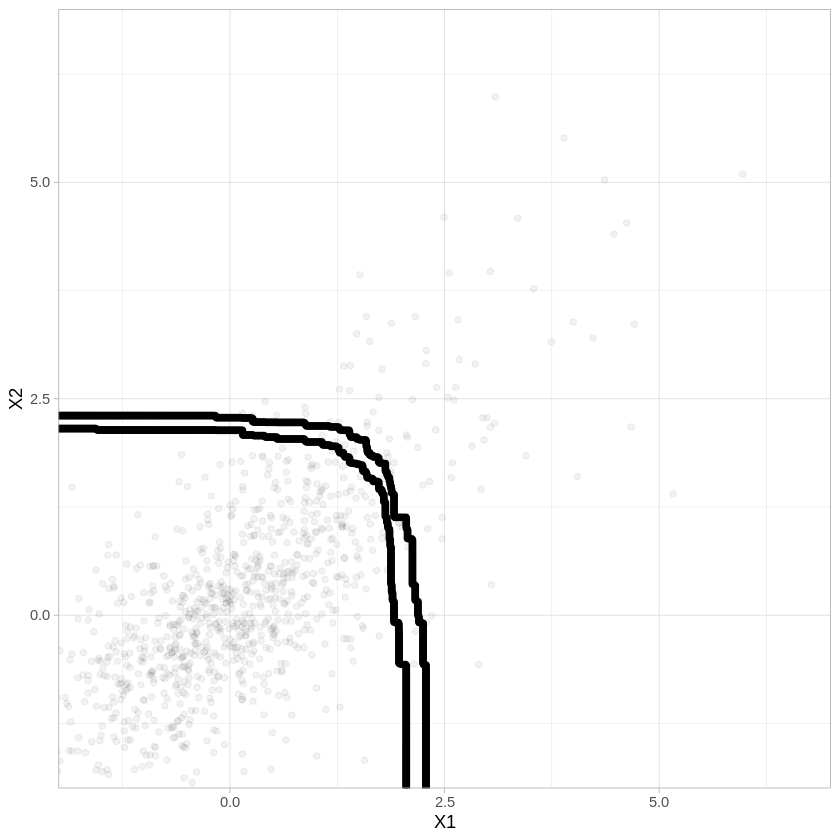

In [19]:
ggplot() + geom_point(data=dat, aes(x=X1, y=X2), alpha=0.05) + 
geom_point(data=tube_bounds[[1]], aes(x=X1, y=X2)) + 
geom_point(data=tube_bounds[[2]], aes(x=X1, y=X2)) + 
coord_cartesian(xlim=c(-2,7), ylim=c(-2,7), expand=FALSE) + theme_light()

In [1]:
# Script to load up base confidence regions and compute their coverages
library(foreach)
library(doSNOW)
library(parallel)
library(mvtnorm)
library(data.table)
source('~/isolines_uq/scripts/R/auxiliary_scripts/distributionIsolines.R')

###### USER-SPECIFIED PARAMETERS ######

ns <- c(1000, 5000, 10000, 25000, 100000, 500000, 1000000)
distribution <- 'bivt'
numCoords <- 500
load_create_tag <- 'empsurv'
ps <- c(0.1, 0.05, 0.01)
alphas <- c(0.05, 0.1, 0.01)
beta_func_labs <- c('0.5', 'sqrt\\(log\\(n\\)/n\\)')

# bounds of grid you used to draw the regions (will be used for drawing true isolines)
lvlset_lbs <- c(-5, -5)
lvlset_ubs <- c(10, 10)

# bounds of grid on which region bhats were calculated
ubs <- c(5, 5)
lbs <- c(-2, -2)

# grid resolution used to draw regions (not used in computations, solely for bookkeeping)
gticks <- 400

n_cores <- 15
#######################################

# tag to keep track of which grid you used to construct your confidence regions
grid_tag <- paste0(gticks, 'x', gticks, '_on_[', lbs[1], ',', ubs[1], ']x[',
                  lbs[2], ',', ubs[2], ']')

if (distribution=='bivt'){
    isolineFunc <- drawBivtIsoline
} else if (distribution=='bivgauss') {
    isolineFunc <- drawBivGaussIsoline
} else if (distribution=='karachi'){
    isolineFunc <- drawKarachiIsoline
}

# create list of isoline basded on desired ps
isolines <- list()
for (i in 1:length(ps)) {
    isolines[[as.character(ps[i])]] <- isolineFunc(numCoords=numCoords, gridUbs=lvlset_ubs, gridLbs=lvlset_lbs, prob=ps[i]) 
}

# loading and saving paths
load_path <- paste0('/pscratch/sd/j/jbbutler/sims/regions/base_confregs_', 
		    load_create_tag, '/', distribution, '/', grid_tag, '/')
save_path <- paste0('/pscratch/sd/j/jbbutler/sims/regions/base_coverage_', 
                    load_create_tag, '/', distribution, '/', grid_tag, '/')
dir.create(save_path)

# get a list of the possible survfunc simulations to load, all differing by sample size
simulated_survfuncs <- list.files(load_path)
# get the file names that match the desired ns above
str_ns <- as.character(ns)
match_inds <- match(ns, as.integer(do.call(rbind.data.frame, strsplit(simulated_survfuncs, 'n_'))[,1]))
desired_ns <- simulated_survfuncs[match_inds]

# get regular expressions correspdonding to above choices of n, alpha, etc.
# to be used to search for the right files when loading up confregs
ps <- paste(paste0('p', ps), collapse='|')
alphas <- paste(paste0('alpha', alphas), collapse='|')
beta_func_labs <- paste(paste0('beta', beta_func_labs), collapse='|')

parallelizedCode <-  function(ind) {

    # grab desired simulations
    sim_confregs <- readRDS(paste0(sims_path, '/simulation_', ind, '.RData'))
    dat <- sim_confregs$data
    # get rid of the last name, since that's the data and not confidence region
    confreg_names <- names(sim_confregs)
    mask <- grepl(ps, confreg_names) & 
	    grepl(alphas, confreg_names) & 
	    grepl(beta_func_labs, confreg_names)
    sim_confregs <- sim_confregs[mask]
    res <- vector(mode='list', length=length(sim_confregs))
    # determine coverage for each desired confreg, for this simulation
    for (i in 1:length(res)) {

	confreg <- sim_confregs[[i]]
	sim_lst <- list()
        sim_lst$n <- n
        sim_lst$alpha <- confreg$alpha
        sim_lst$p <- confreg$p
        sim_lst$beta_func <- confreg$beta_func
	sim_lst$sim_num <- ind
        
        p_tag <- as.character(sim_lst$p)

        #tube_top <- confreg$tube_top
        #tube_bottom <- confreg$tube_bottom

        isoline <- isolines[[p_tag]]

        # old way of evaluating coverage
	#comp1xs <- CJ(top_x=tube_top[,1], iso_x=isoline[,1], sorted=FALSE)
        #comp1ys <- CJ(top_y=tube_top[,2], iso_y=isoline[,2], sorted=FALSE)
        #comp2xs <- CJ(iso_x=isoline[,1], bott_x=tube_bottom[,1], sorted=FALSE)
        #comp2ys <- CJ(iso_y=isoline[,2], bott_y=tube_bottom[,2], sorted=FALSE)

        #upper_cov <- !any((comp1xs[[1]] <= comp1xs[[2]]) & (comp1ys[[1]] <= comp1ys[[2]]))
        #lower_cov <- !any((comp2xs[[1]] <= comp2xs[[2]]) & (comp2ys[[1]] <= comp2ys[[2]]))
        #covered <- upper_cov & lower_cov

        # new way of determining coverage
	bhat <- confreg$bhat
	p <- confreg$p

	findEmpSurv <- function(row) {
    		return(mean((dat[,1] > row[[1]]) & (dat[,2] > row[[2]])))
	}
	# evaluate if each point on the isoline satisfies conditions of being in confidence set
	survs <- apply(isoline, 1, findEmpSurv)
	covered <- all((survs <= p + bhat) & (survs >= p - bhat))

	sim_lst$covered <- covered

	res[[i]] <- sim_lst

    }
    results_sim <- do.call(rbind.data.frame, res)
    
    return(results_sim)
}


Warning message:
“package ‘foreach’ was built under R version 4.2.3”
Loading required package: iterators

Warning message:
“package ‘iterators’ was built under R version 4.2.3”
Loading required package: snow

Warning message:
“package ‘snow’ was built under R version 4.2.3”

Attaching package: ‘parallel’


The following objects are masked from ‘package:snow’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, clusterSplit, makeCluster, parApply,
    parCapply, parLapply, parRapply, parSapply, splitIndices,
    stopCluster


Warning message:
“package ‘data.table’ was built under R version 4.2.3”
Warning message in dir.create(save_path):
“'/pscratch/sd/j/jbbutler/sims/regions/base_coverage_empsurv/bivt/400x400_on_[-2,5]x[-2,5]' already exists”


In [12]:
j <- 7
nsim <- desired_ns[j]
sims_path <- paste0(load_path, '/', nsim)
n <- as.numeric(strsplit(nsim, 'n_')[[1]][1])

n_iter <- length(list.files(sims_path))

In [13]:
parallelizedCode(4)

n,alpha,p,beta_func,sim_num,covered
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>
1e+06,0.01,0.10,0.5,4,TRUE
1e+06,0.05,0.10,0.5,4,TRUE
1e+06,0.10,0.10,0.5,4,TRUE
1e+06,0.01,0.10,sqrt(log(n)/n),4,TRUE
1e+06,0.05,0.10,sqrt(log(n)/n),4,TRUE
1e+06,0.10,0.10,sqrt(log(n)/n),4,TRUE
1e+06,0.01,0.01,0.5,4,TRUE
1e+06,0.05,0.01,0.5,4,TRUE
1e+06,0.10,0.01,0.5,4,TRUE
